<a href="https://colab.research.google.com/github/shahtvisha/TextSummarizationSeq2Seq2LSTM/blob/main/PubmedTextSummarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [ ]:
import datasets
import pandas as pd
import numpy as np

In [ ]:
from datasets import load_dataset
dataset = load_dataset("ccdv/pubmed-summarization")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for ccdv/pubmed-summarization contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ccdv/pubmed-summarization
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `d

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract'],
        num_rows: 119924
    })
    validation: Dataset({
        features: ['article', 'abstract'],
        num_rows: 6633
    })
    test: Dataset({
        features: ['article', 'abstract'],
        num_rows: 6658
    })
})

In [ ]:
dataset['test'][0]

{'article': "anxiety affects quality of life in those living with parkinson 's disease ( pd ) more so than overall cognitive status , motor deficits , apathy , and depression [ 13 ] . \n although anxiety and depression are often related and coexist in pd patients , recent research suggests that anxiety rather than depression is the most prominent and prevalent mood disorder in pd [ 5 , 6 ] . yet , \n our current understanding of anxiety and its impact on cognition in pd , as well as its neural basis and best treatment practices , remains meager and lags far behind that of depression . \n overall , neuropsychiatric symptoms in pd have been shown to be negatively associated with cognitive performance . \n for example , higher depression scores have been correlated with lower scores on the mini - mental state exam ( mmse ) [ 8 , 9 ] as well as tests of memory and executive functions ( e.g. , attention ) [ 1014 ] . \n likewise , apathy and anhedonia in pd patients have been associated with

In [ ]:
dataset['validation'][0]

{'article': "venous thromboembolism ( vte ) comprising of deep vein thrombosis ( dvt ) and pulmonary embolism ( pe ) can result in significant mortality , morbidity , and healthcare expenditure . \n approximately , one - third of patients with symptomatic vte manifests pe , whereas two - thirds manifest dvt alone . \n both dvt and pe can be clinically silent ( asymptomatic ) and hence not suspected . \n if undiagnosed , asymptomatic vte can lead to chronic venous disease or recurrent vte and long - term debilitating sequelae such as postthrombotic syndrome and chronic thromboembolic pulmonary hypertension . \n vte is not only disabling but also prolongs hospital stay and increases the cost of treatment . \n along with myocardial infarction and arrhythmia ( due to electrolyte imbalance ) , pe is one of the commonest causes of sudden unexplained deaths in hospitalized patients . \n it is estimated that 20 million cases of lower extremity dvt occur in the usa alone . \n the prevailing not

Data Exploration

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Summary statistics
num_articles = len(dataset['train']['article'])
avg_article_length = sum(len(article) for article in dataset['train']['article']) / num_articles
avg_abstract_length = sum(len(abstract) for abstract in dataset['train']['abstract']) / num_articles

print("Number of articles:", num_articles)
print("Average article length:", avg_article_length)
print("Average abstract length:", avg_abstract_length)


Number of articles: 119924
Average article length: 17585.276233281078
Average abstract length: 1233.1884860411594


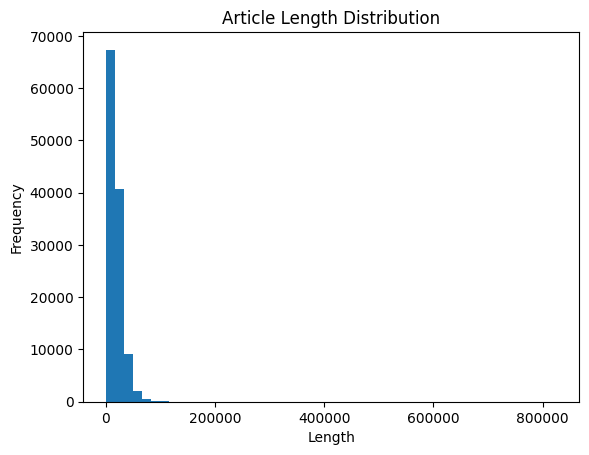

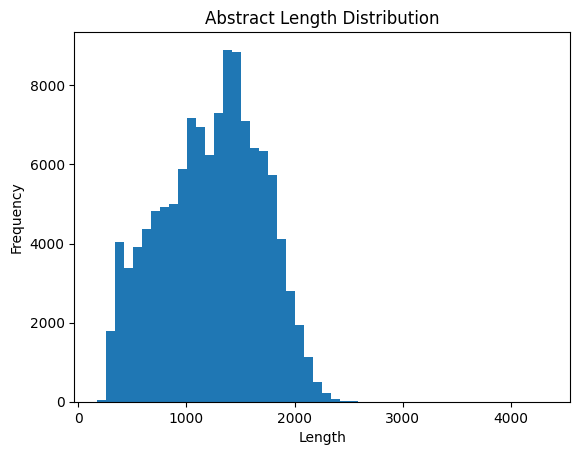

In [ ]:
# Article length distribution
plt.hist([len(article) for article in dataset['train']['article']], bins=50)
plt.title('Article Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# Abstract length distribution
plt.hist([len(abstract) for abstract in dataset['train']['abstract']], bins=50)
plt.title('Abstract Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

Preprocessing

In [ ]:
import re

In [ ]:
def text_strip(column):
    preprocessed_text = []
    for row in column:
        row = re.sub("(\\t)", ' ', str(row)).lower()  # remove escape characters
        row = re.sub("(\\r)", ' ', str(row)).lower()
        row = re.sub("(\\n)", ' ', str(row)).lower()
        row = re.sub("(\.\.+)", ' ', str(row)).lower()   # remove . if it occurs more than one time consecutively

        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower()  # remove <>()|&©ø"',;?~*!

        row = re.sub("(\.\s+)", ' ', str(row)).lower()  # remove full stop at end of words(not between)
        row = re.sub("(\-\s+)", ' ', str(row)).lower()  # remove - at end of words(not between)
        row = re.sub("(\:\s+)", ' ', str(row)).lower()  # remove : at end of words(not between)

        row = re.sub("(\s+.\s+)", ' ', str(row)).lower()  # remove any single characters hanging between 2 spaces
        row = re.sub(r'\n', ' ', str(row))# remove next line
        row = re.sub(r'(\s*\\n\s*)', ' ', row)  # Remove "\n" substring with surrounding spaces
        row= re.sub(r'\s+\.', '.', row)

        # Replace any URL with its domain
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(row))
        except:
            pass  # there might be emails with no URL in them

        row = re.sub("(\s+)", ' ', str(row)).lower()  # remove multiple spaces

        # Should always be last
        row = re.sub("(\s+.\s+)", ' ', str(row)).lower()  # remove any single characters hanging between 2 spaces

        preprocessed_text.append(row.strip())

    return preprocessed_text

In [ ]:
# Initialize a dictionary to store preprocessed dataset
preprocessed_dataset = {}

# Preprocess the validation data
preprocessed_dataset['validation'] = []
for i, row in enumerate(dataset['validation']):
    preprocessed_row = {}
    if 'article' in row:
        preprocessed_row['article'] = text_strip([row['article']])[0]
    if 'abstract' in row:
        preprocessed_row['abstract'] = text_strip([row['abstract']])[0]
    preprocessed_dataset['validation'].append(preprocessed_row)

# Display preprocessed dataset
for split, data in preprocessed_dataset.items():
    print(f"{split}:")
    for i, row in enumerate(data[:5]):  # Prints 5 elements
        print(f"Row {i+1}:")
        if 'article' in row:
            print(f"Article: {row['article']}")
        if 'abstract' in row:
            print(f"Abstract: {row['abstract']}")
    print()


validation:
Row 1:
Article: venous thromboembolism vte comprising of deep vein thrombosis dvt and pulmonary embolism pe can result in significant mortality morbidity and healthcare expenditure approximately one third of patients with symptomatic vte manifests pe whereas two thirds manifest dvt alone both dvt and pe can be clinically silent asymptomatic and hence not suspected if undiagnosed asymptomatic vte can lead to chronic venous disease or recurrent vte and long term debilitating sequelae such as postthrombotic syndrome and chronic thromboembolic pulmonary hypertension vte is not only disabling but also prolongs hospital stay and increases the cost of treatment along with myocardial infarction and arrhythmia due to electrolyte imbalance pe is one of the commonest causes of sudden unexplained deaths in hospitalized patients it is estimated that 20 million cases of lower extremity dvt occur in the usa alone the prevailing notion that the incidence of vte in asians is less than that 

In [ ]:
# Preprocess a subset of the validation data
preprocessed_dataset['test'] = []
for i, row in enumerate(dataset['test']):
    # if i >= subset_size:
    #     break
    preprocessed_row = {}
    if 'article' in row:
        preprocessed_row['article'] = text_strip([row['article']])[0]
    if 'abstract' in row:
        preprocessed_row['abstract'] = text_strip([row['abstract']])[0]
    preprocessed_dataset['test'].append(preprocessed_row)


# Display preprocessed dataset
for split, data in preprocessed_dataset.items():
    print(f"{split}:")
    for i, row in enumerate(preprocessed_dataset['test'][:5]):  # Prints 5 elements
        print(f"Row {i+1}:")
        if 'article' in row:
            print(f"Article: {row['article']}")
        if 'abstract' in row:
            print(f"Abstract: {row['abstract']}")
    print()




validation:
Row 1:
Article: anxiety affects quality of life in those living with parkinson disease pd more so than overall cognitive status motor deficits apathy and depression 13 although anxiety and depression are often related and coexist in pd patients recent research suggests that anxiety rather than depression is the most prominent and prevalent mood disorder in pd yet our current understanding of anxiety and its impact on cognition in pd as well as its neural basis and best treatment practices remains meager and lags far behind that of depression overall neuropsychiatric symptoms in pd have been shown to be negatively associated with cognitive performance for example higher depression scores have been correlated with lower scores on the mini mental state exam mmse as well as tests of memory and executive functions e.g attention 1014 likewise apathy and anhedonia in pd patients have been associated with executive dysfunction 10 1523 however few studies have specifically investiga

In [ ]:
preprocessed_dataset['validation'][0]
preprocessed_dataset['test'][0]

{'article': 'anxiety affects quality of life in those living with parkinson disease pd more so than overall cognitive status motor deficits apathy and depression 13 although anxiety and depression are often related and coexist in pd patients recent research suggests that anxiety rather than depression is the most prominent and prevalent mood disorder in pd yet our current understanding of anxiety and its impact on cognition in pd as well as its neural basis and best treatment practices remains meager and lags far behind that of depression overall neuropsychiatric symptoms in pd have been shown to be negatively associated with cognitive performance for example higher depression scores have been correlated with lower scores on the mini mental state exam mmse as well as tests of memory and executive functions e.g attention 1014 likewise apathy and anhedonia in pd patients have been associated with executive dysfunction 10 1523 however few studies have specifically investigated the relatio

In [ ]:
print(dataset['train'][:5])

{'article': ["a recent systematic analysis showed that in 2011 , 314 ( 296 - 331 ) million children younger than 5 years were mildly , moderately or severely stunted and 258 ( 240 - 274 ) million were mildly , moderately or severely underweight in the developing countries . \n in iran a study among 752 high school girls in sistan and baluchestan showed prevalence of 16.2% , 8.6% and 1.5% , for underweight , overweight and obesity , respectively . \n the prevalence of malnutrition among elementary school aged children in tehran varied from 6% to 16% . \n anthropometric study of elementary school students in shiraz revealed that 16% of them suffer from malnutrition and low body weight . \n snack should have 300 - 400 kcal energy and could provide 5 - 10 g of protein / day . nowadays , school nutrition programs are running as the national programs , world - wide . national school lunch program in the united states \n there are also some reports regarding school feeding programs in develop

In [ ]:
import pandas as pd

# Define batch size
batch_size = 10000

# Initialize an empty list to store preprocessed rows
preprocessed_rows = []

# Process the first 10,000 rows of the training dataset
for i in range(0, batch_size):
    row = dataset['train'][i]
    preprocessed_row = {}
    if 'article' in row:
        preprocessed_row['article'] = text_strip([row['article']])[0]
    if 'abstract' in row:
        preprocessed_row['abstract'] = text_strip([row['abstract']])[0]
    preprocessed_rows.append(preprocessed_row)

# Convert the list of preprocessed rows to a dataframe
preprocessed_df = pd.DataFrame(preprocessed_rows)

# Save the dataframe to a CSV file
# preprocessed_df.to_csv('preprocessed_train_10000.csv', index=False)

print("Preprocessing completed.")


Preprocessing completed.


In [ ]:
preprocessed_rows1 = []

# Process the next 10,000 rows of the training dataset
for i in range(batch_size, 4 * batch_size):
    row = dataset['train'][i]
    preprocessed_row = {}
    if 'article' in row:
        preprocessed_row['article'] = text_strip([row['article']])[0]
    if 'abstract' in row:
        preprocessed_row['abstract'] = text_strip([row['abstract']])[0]
    preprocessed_rows1.append(preprocessed_row)

# Convert the list of preprocessed rows to a dataframe
new_preprocessed_df = pd.DataFrame(preprocessed_rows1)
combined_preprocessed_df = pd.concat([preprocessed_df, new_preprocessed_df], ignore_index=True)
combined_preprocessed_df

,article,abstract
0,a recent systematic analysis showed that in 20...,background the present study was carried out t...
1,it occurs in more than 50% of patients and may...,backgroundanemia in patients with cancer who a...
2,tardive dystonia td rarer side effect after lo...,tardive dystonia td is serious side effect of ...
3,lepidoptera include agricultural pests that th...,many lepidopteran insects are agricultural pes...
4,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough ...
...,...,...
39995,human hepatitis virus hbv is an enveloped dna ...,more than 350 million people worldwide are per...
39996,most therapeutic drugs fig are derived origina...,upon emergence of modern anticancer therapy me...
39997,empyema thoracis is an uncommon complication o...,background empyema thoracis in children causes...
39998,water and solute permeability across lipid mem...,despite intense study over many years the mech...


In [ ]:
preprocessed_rows2 = []

# Process the next 10,000 rows of the training dataset
for i in range(4*batch_size, 8*batch_size):
    row = dataset['train'][i]
    preprocessed_row = {}
    if 'article' in row:
        preprocessed_row['article'] = text_strip([row['article']])[0]
    if 'abstract' in row:
        preprocessed_row['abstract'] = text_strip([row['abstract']])[0]
    preprocessed_rows2.append(preprocessed_row)

# Convert the list of preprocessed rows to a dataframe
new_preprocessed_df1 = pd.DataFrame(preprocessed_rows2)
final_preprocessed_df = pd.concat([combined_preprocessed_df, new_preprocessed_df1], ignore_index=True)
final_preprocessed_df

,article,abstract
0,a recent systematic analysis showed that in 20...,background the present study was carried out t...
1,it occurs in more than 50% of patients and may...,backgroundanemia in patients with cancer who a...
2,tardive dystonia td rarer side effect after lo...,tardive dystonia td is serious side effect of ...
3,lepidoptera include agricultural pests that th...,many lepidopteran insects are agricultural pes...
4,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough ...
...,...,...
79995,zno is an attractive direct wide band gap eg 3...,zno was grown on sapphire substrate by metal o...
79996,post operative nausea and vomiting ponv is com...,background and aims post operative nausea and ...
79997,intravenous immunoglobulin ivig replacement th...,intravenous immunoglobulin has been shown to d...
79998,complete familiarity with external and interna...,most often clinician working on maxillary firs...


In [ ]:
preprocessed_rows3 = []

# Process the next 10,000 rows of the training dataset
for i in range(8*batch_size, 11*batch_size):
    row = dataset['train'][i]
    preprocessed_row = {}
    if 'article' in row:
        preprocessed_row['article'] = text_strip([row['article']])[0]
    if 'abstract' in row:
        preprocessed_row['abstract'] = text_strip([row['abstract']])[0]
    preprocessed_rows3.append(preprocessed_row)

# Convert the list of preprocessed rows to a dataframe
new_preprocessed_df2 = pd.DataFrame(preprocessed_rows3)
final_preprocessed_df1 = pd.concat([final_preprocessed_df, new_preprocessed_df2], ignore_index=True)
final_preprocessed_df1

,article,abstract
0,a recent systematic analysis showed that in 20...,background the present study was carried out t...
1,it occurs in more than 50% of patients and may...,backgroundanemia in patients with cancer who a...
2,tardive dystonia td rarer side effect after lo...,tardive dystonia td is serious side effect of ...
3,lepidoptera include agricultural pests that th...,many lepidopteran insects are agricultural pes...
4,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough ...
...,...,...
109995,splenic metastasis is very rare occurrence in ...,splenic metastasis from malignant melanoma is ...
109996,huntington disease hd and parkinson disease pd...,nmda and ampa type glutamate receptors and the...
109997,the development of inflammatory periodontal di...,purposethe development of inflammatory periodo...
109998,continuous intrathecal baclofen infusion thera...,percutaneous endoscopic gastrostomy peg is the...


In [ ]:
# Convert DataFrame to list of dictionaries
preprocessed_rows_train = final_preprocessed_df1.to_dict(orient='records')

# Assign the list to preprocessed_dataset['train']
preprocessed_dataset['train'] = preprocessed_rows_train


Add start to end tokens

In [ ]:
# Initialize a dictionary to store preprocessed dataset with tokens for each split
preprocessed_dataset_with_tokens = {}

# Loop through all possible splits (train, test, and validation)
for split in ['train', 'test', 'validation']:
    # Check if the current split exists in the preprocessed dataset
    if split in preprocessed_dataset:
        # Initialize a list to store preprocessed rows for the current split
        preprocessed_dataset_with_tokens[split] = []

        # Add start and end tokens to the preprocessed dataset for the current split
        for row in preprocessed_dataset[split]:
            preprocessed_row_with_tokens = {}
            if 'article' in row:
                article_with_tokens = f"<start> {row['article']} <end>"
                preprocessed_row_with_tokens['article'] = article_with_tokens
            if 'abstract' in row:
                abstract_with_tokens = f"<start> {row['abstract']} <end>"
                preprocessed_row_with_tokens['abstract'] = abstract_with_tokens
            preprocessed_dataset_with_tokens[split].append(preprocessed_row_with_tokens)
    else:
        # If the current split is missing, print a message
        print(f"Split '{split}' is missing from the preprocessed dataset.")

# Display preprocessed dataset with start and end tokens for each split
for split, data in preprocessed_dataset_with_tokens.items():
    print(f"{split}:")
    for i, row in enumerate(data[:5]):  # Print only the first 5 elements
        print(f"Row {i+1}:")
        if 'article' in row:
            print(f"Article: {row['article']}")
        if 'abstract' in row:
            print(f"Abstract: {row['abstract']}")
    print()


train:
Row 1:
Article: <start> a recent systematic analysis showed that in 2011 314 296 331 million children younger than years were mildly moderately or severely stunted and 258 240 274 million were mildly moderately or severely underweight in the developing countries in iran study among 752 high school girls in sistan and baluchestan showed prevalence of 16.2% 8.6% and 1.5% for underweight overweight and obesity respectively the prevalence of malnutrition among elementary school aged children in tehran varied from 6% to 16% anthropometric study of elementary school students in shiraz revealed that 16% of them suffer from malnutrition and low body weight snack should have 300 400 kcal energy and could provide 10 of protein day nowadays school nutrition programs are running as the national programs world wide national school lunch program in the united states there are also some reports regarding school feeding programs in developing countries in vietnam school base program showed an i

Tokenization

Padding

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
def tokenize_data(texts, max_len=None, thresh=4):
    # Initialize tokenizer
    tokenizer = Tokenizer()

    # Fit tokenizer on texts
    tokenizer.fit_on_texts(texts)

    # Count the number of words with frequency less than threshold
    rare_words_count = sum(1 for value in tokenizer.word_counts.values() if value < thresh)

    # Calculate total number of words and total frequency
    total_words = len(tokenizer.word_counts)
    total_freq = sum(tokenizer.word_counts.values())

    # Print percentage of rare words and total coverage
    print("% of rare words in vocabulary:", (rare_words_count / total_words) * 100)
    print("Total Coverage of rare words:", (rare_words_count / total_freq) * 100)

    # Create tokenizer with vocabulary excluding rare words
    tokenizer = Tokenizer(num_words=total_words - rare_words_count + 1)
    tokenizer.fit_on_texts(texts)

    # Convert text sequences into integer sequences
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad sequences if max_len is provided
    if max_len:
        sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    # Return tokenizer and sequences
    return tokenizer, sequences

In [ ]:
def preprocess_split(split_data):
    # Initialize a dictionary to store preprocessed data for the split
    preprocessed_data = {}

    # Extract articles and abstracts from the split data
    articles = [row['article'] for row in split_data]
    abstracts = [row['abstract'] for row in split_data]

    # Tokenize articles
    article_tokenizer, article_sequences = tokenize_data(articles, max_len=100)

    # Tokenize abstracts
    abstract_tokenizer, abstract_sequences = tokenize_data(abstracts, max_len=15)

    # Store tokenizers and sequences in preprocessed data
    preprocessed_data['article_tokenizer'] = article_tokenizer
    preprocessed_data['abstract_tokenizer'] = abstract_tokenizer
    preprocessed_data['article_sequences'] = article_sequences
    preprocessed_data['abstract_sequences'] = abstract_sequences

    return preprocessed_data

In [ ]:
# Process each split individually
preprocessed_dataset_with_tokens = {}
for split, data in preprocessed_dataset.items():
    preprocessed_dataset_with_tokens[split] = preprocess_split(data)

% of rare words in vocabulary: 63.412334192493866
Total Coverage of rare words: 0.6965791406071963
% of rare words in vocabulary: 60.38229194842665
Total Coverage of rare words: 2.301766107980567
% of rare words in vocabulary: 63.60044172061694
Total Coverage of rare words: 0.7006080061250304
% of rare words in vocabulary: 60.55639131508633
Total Coverage of rare words: 2.2821158945945075
% of rare words in vocabulary: 71.63226712241142
Total Coverage of rare words: 0.3102935122538497
% of rare words in vocabulary: 62.736356494893855
Total Coverage of rare words: 0.652503172927626


Vocabulary Creation

In [ ]:
# Calculate vocabulary sizes
article_voc_size = preprocessed_dataset_with_tokens['train']['article_tokenizer'].num_words + 1
abstract_voc_size = preprocessed_dataset_with_tokens['train']['abstract_tokenizer'].num_words + 1

print("Size of vocabulary in Article = {}".format(article_voc_size))
print("Size of vocabulary in Abstract = {}".format(abstract_voc_size))

Size of vocabulary in Article = 345917
Size of vocabulary in Abstract = 74476


In [ ]:
voc_size=preprocessed_dataset_with_tokens['train']['article_tokenizer'].num_words + 1
abs_voc_size = preprocessed_dataset_with_tokens['train']['abstract_tokenizer'].num_words + 1


In [ ]:
# Get the sequences for training
x_tr = preprocessed_dataset_with_tokens['train']['article_sequences']
y_tr = preprocessed_dataset_with_tokens['train']['abstract_sequences']

# Get the sequences for validation (if available)
x_val = preprocessed_dataset_with_tokens['validation']['article_sequences']
y_val = preprocessed_dataset_with_tokens['validation']['abstract_sequences']

Model